<a href="https://colab.research.google.com/github/HoanChan/TableVision/blob/main/border_table_detection.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

In [1]:
#@title Cài đặt kiểm tra môi trường và tải mã nguồn để lấy dữ liệu
# Kiểm tra hiện tại có phải đang ở trong colaboratory hay không
import sys

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !git clone https://github.com/HoanChan/TableVision.git TableVision
    %cd TableVision
else:
    print("Running on Local")
prePath = "/content/TableVision/" if IN_COLAB else ""

Running on Local


In [2]:
from utils.ocr import *

detector = init_VietOCR()

Đã cài đặt thư viện nhận diện văn bản


/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model weight /tmp/vgg_seq2seq.pth exsits. Ignore download!


<Figure size 1000x2000 with 0 Axes>

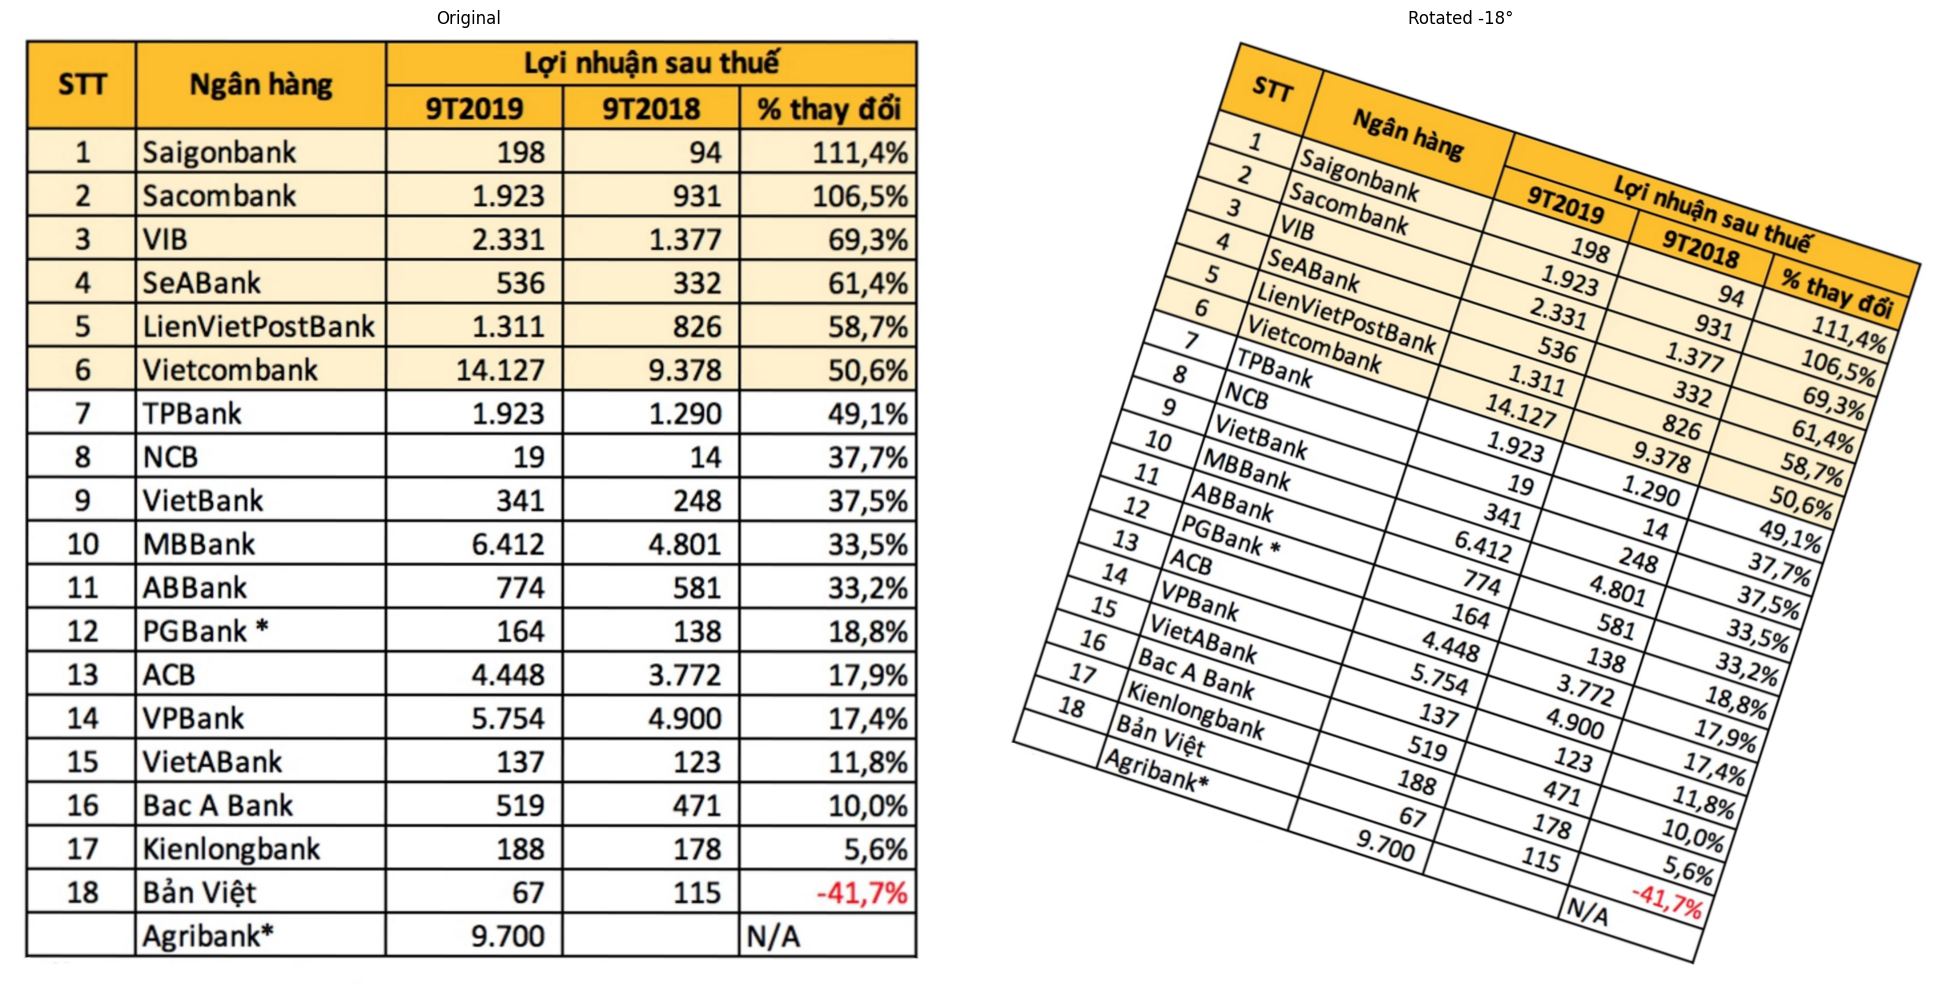

In [3]:
from utils.cv import *
from matplotlib import pyplot as plt
import cv2
import random

image_path = prePath + "sample/xx2.jpg"
image = cv2.imread(image_path)
angle = random.randint(-30, 30)
rotated_image = rotate_image(image, angle)
# thiết lập kích thước hiển thị ảnh
plt.figure(figsize=(10, 20))
# hiển thị ảnh gốc và ảnh đã xoay
display_images_with_labels([(image, "Original"), (rotated_image, f"Rotated {str(angle)}°")], (1, 2), show_axis=False)

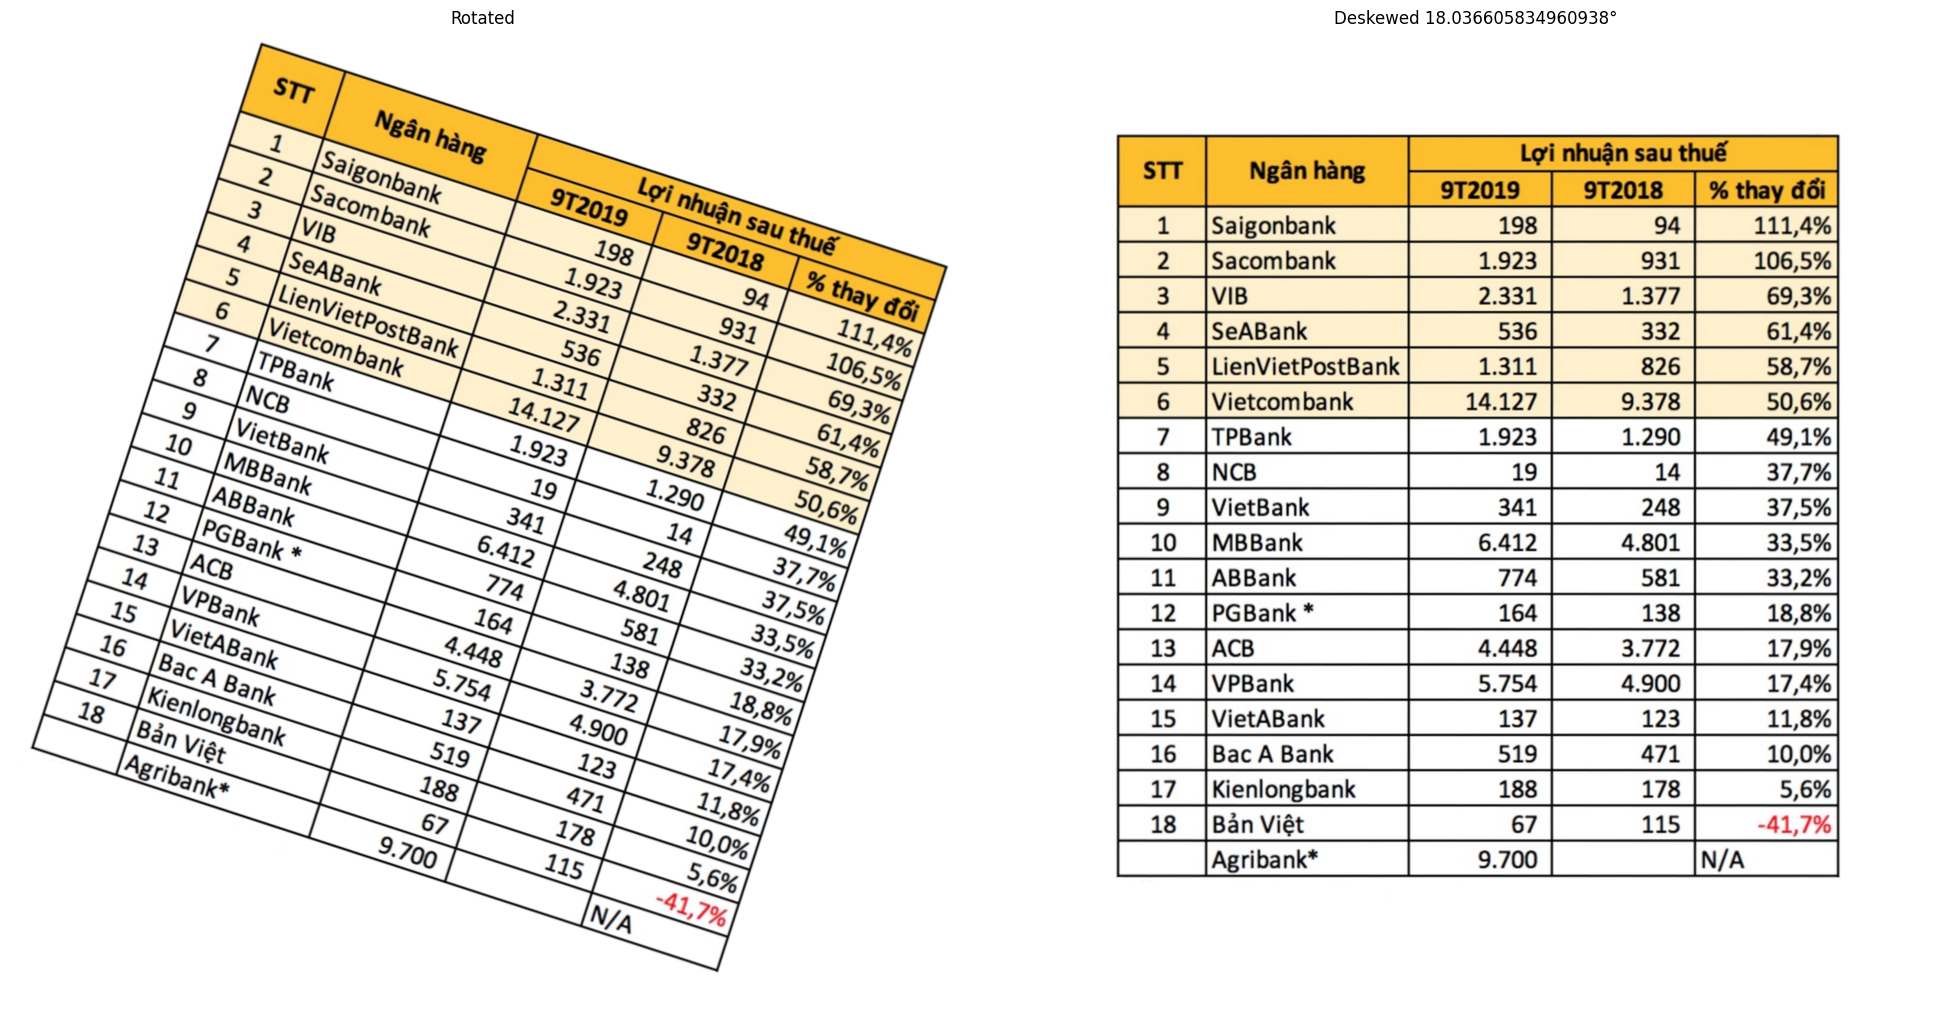

In [4]:
image_ok, calc_angle = deskew_image(rotated_image)
display_images_with_labels([(rotated_image, "Rotated"), (image_ok, f"Deskewed {str(calc_angle)}°")], (1, 2), show_axis=False)

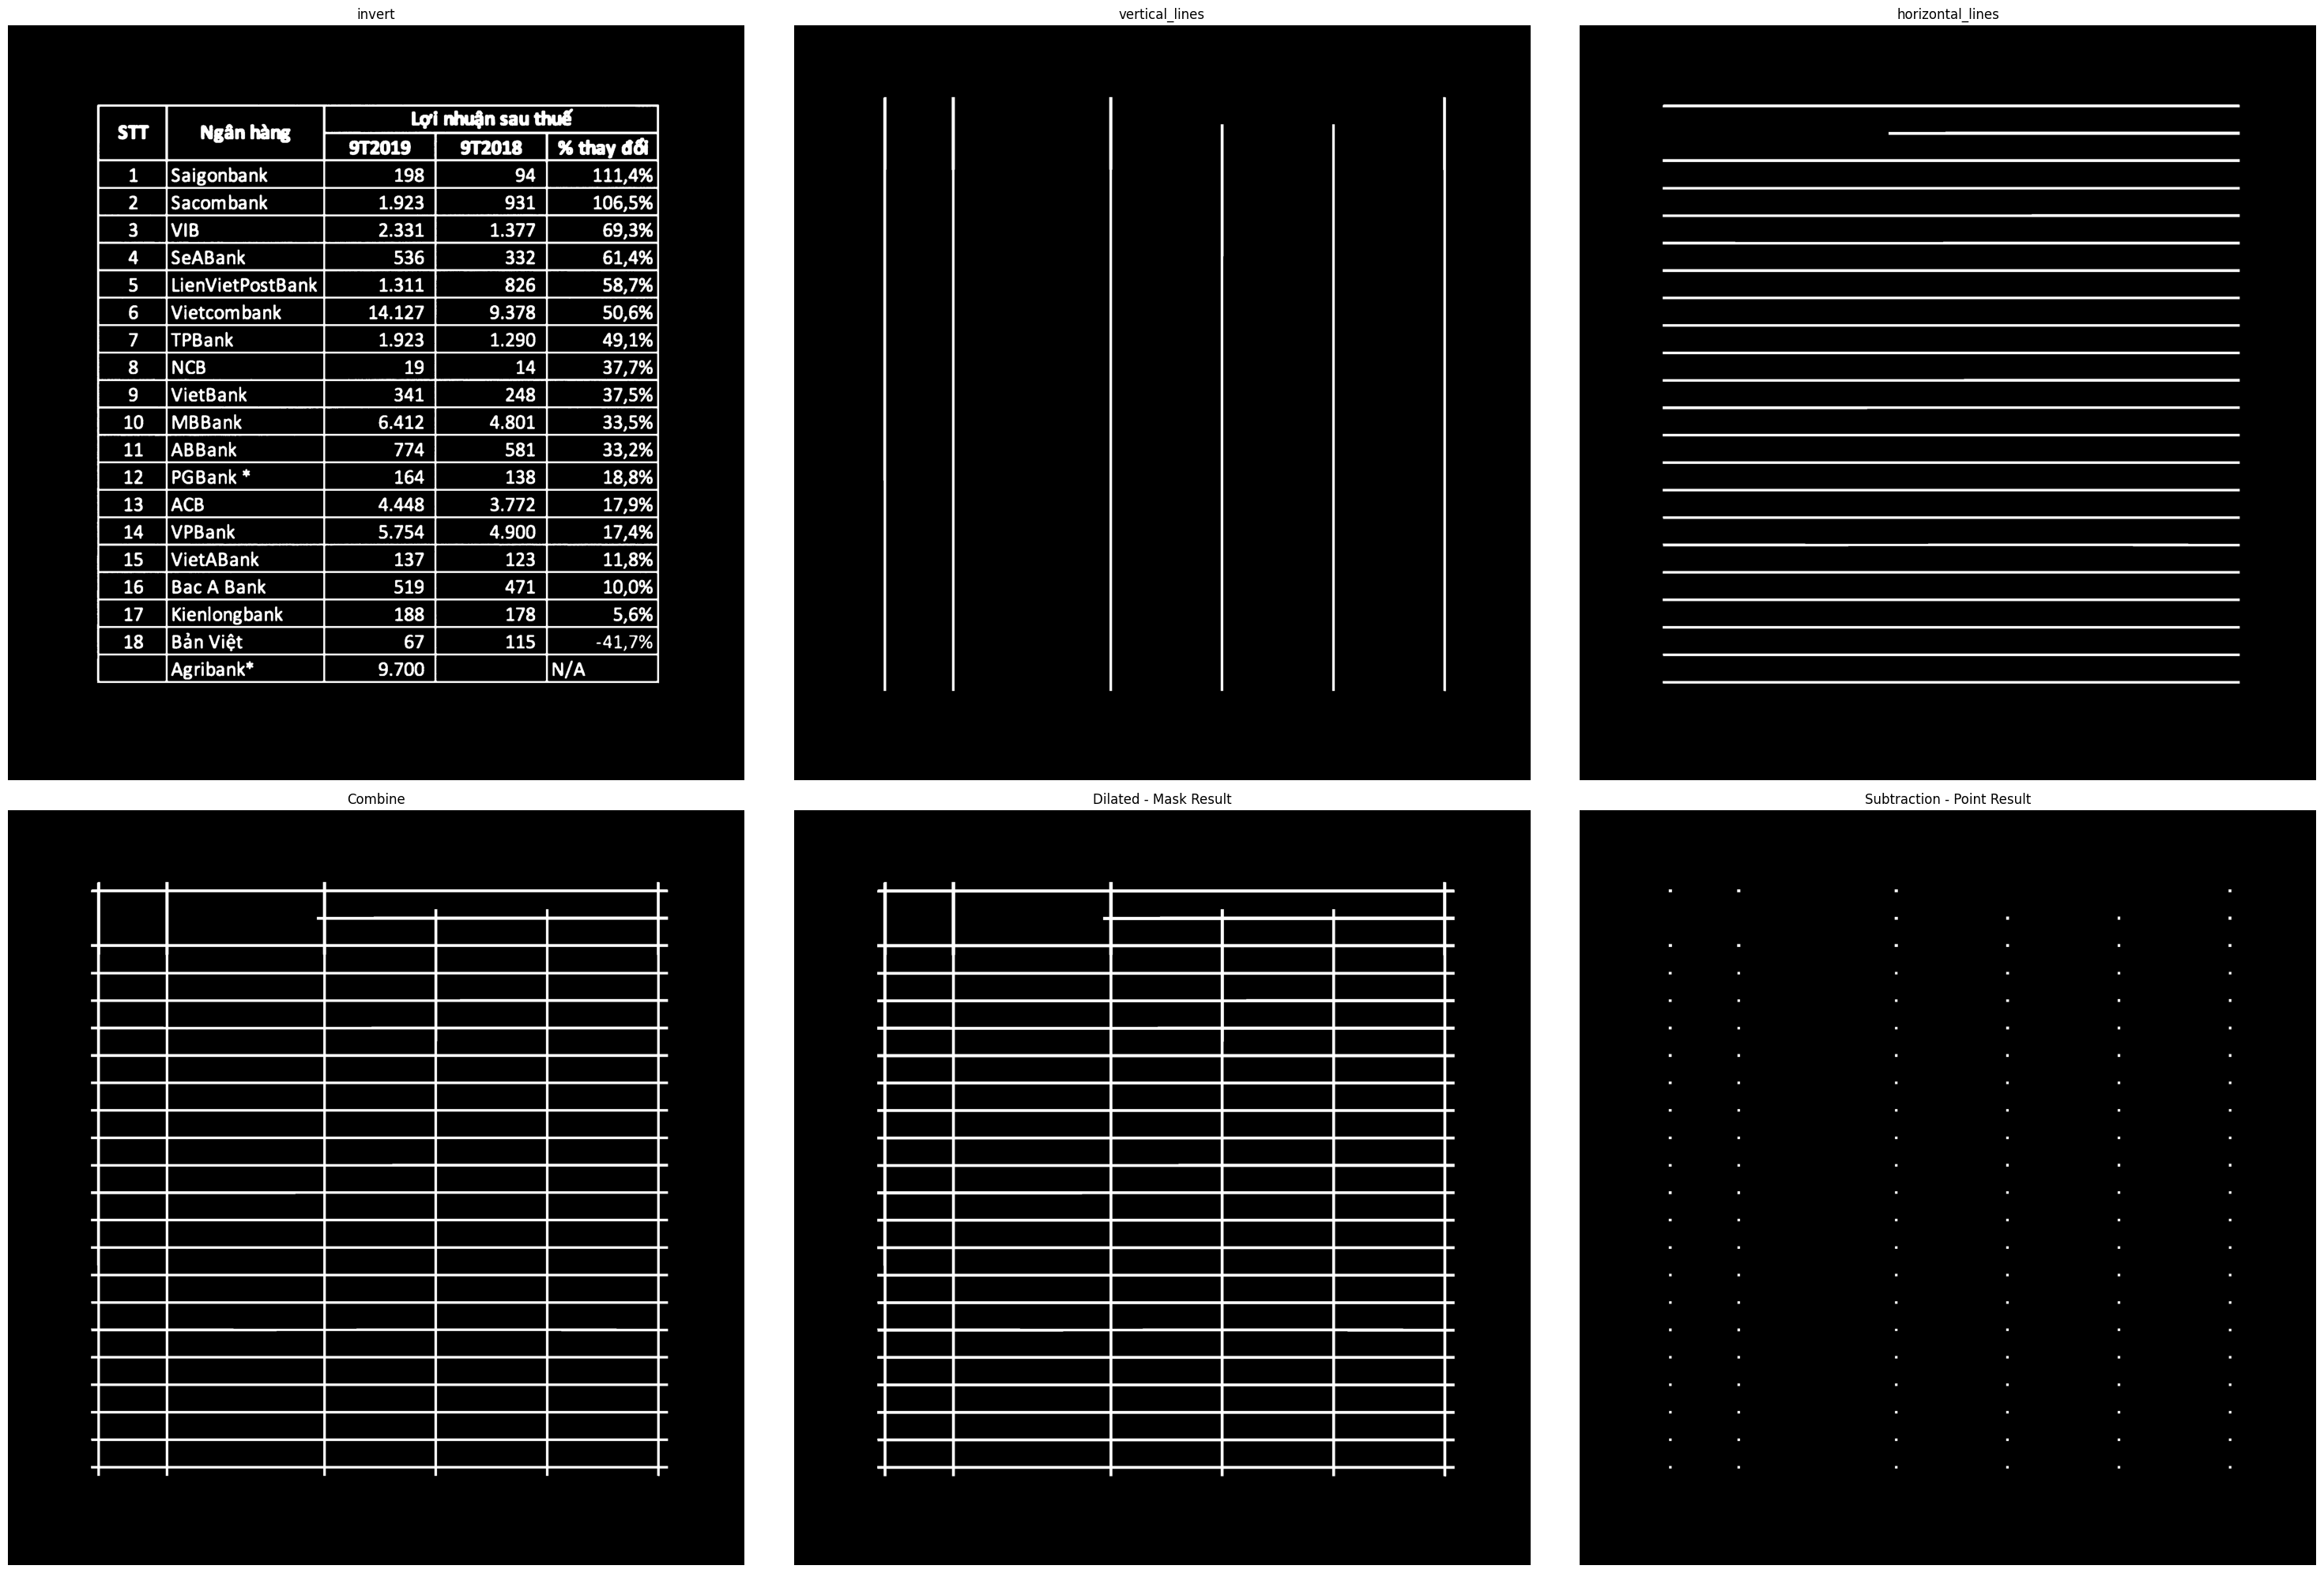

In [5]:
from detection.border_table_detection import *
mask, dots, outImag = find_Lines(image_ok)
num_cols = 3
num_rows = len(outImag) // num_cols if len(outImag) % num_cols == 0 else len(outImag) // num_cols + 1
display_images_with_labels(outImag, (num_rows, num_cols), show_axis=False)

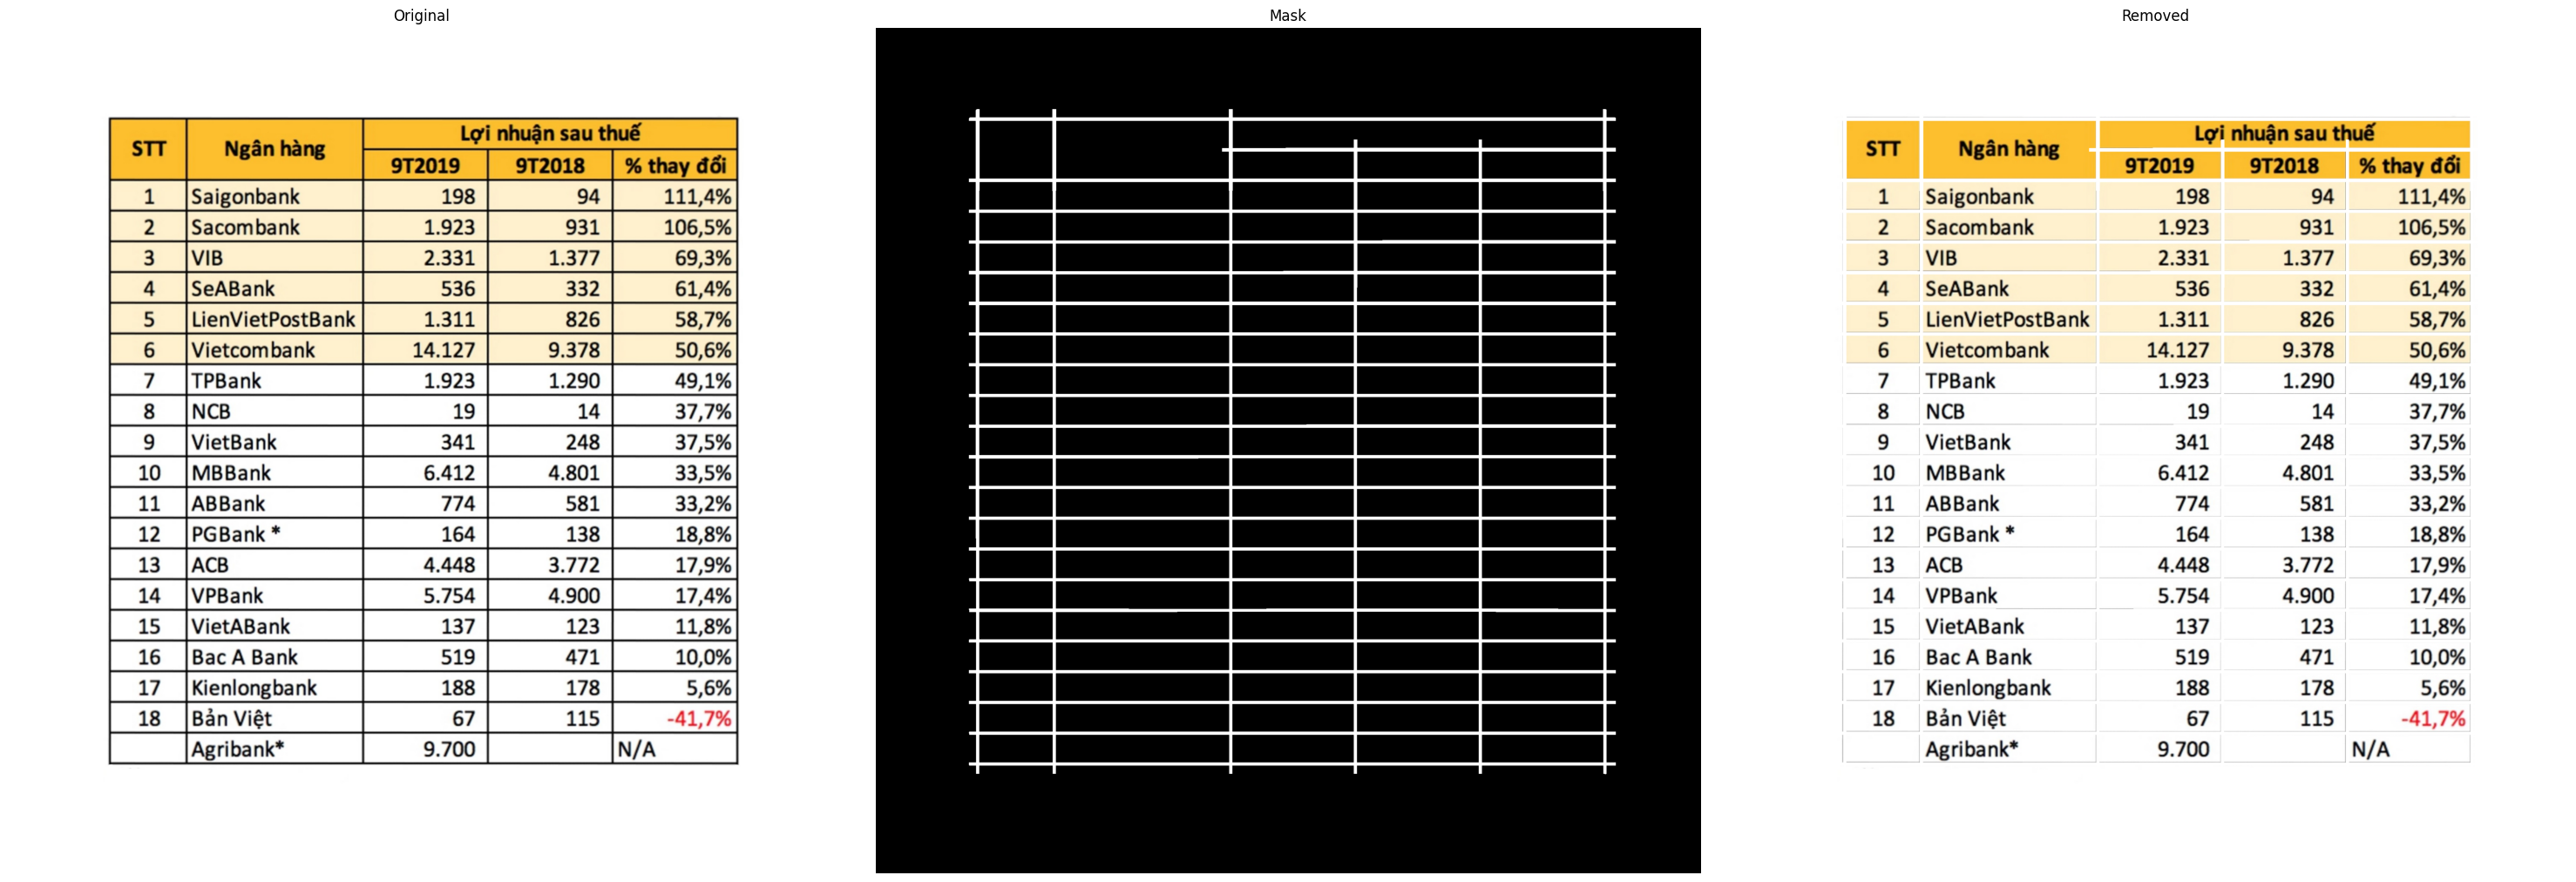

In [6]:
image_removed = remove_regions(image_ok, mask)
display_images_with_labels([(image_ok, "Original"), (mask,'Mask'), (image_removed, "Removed")], (1, 3), show_axis=False)

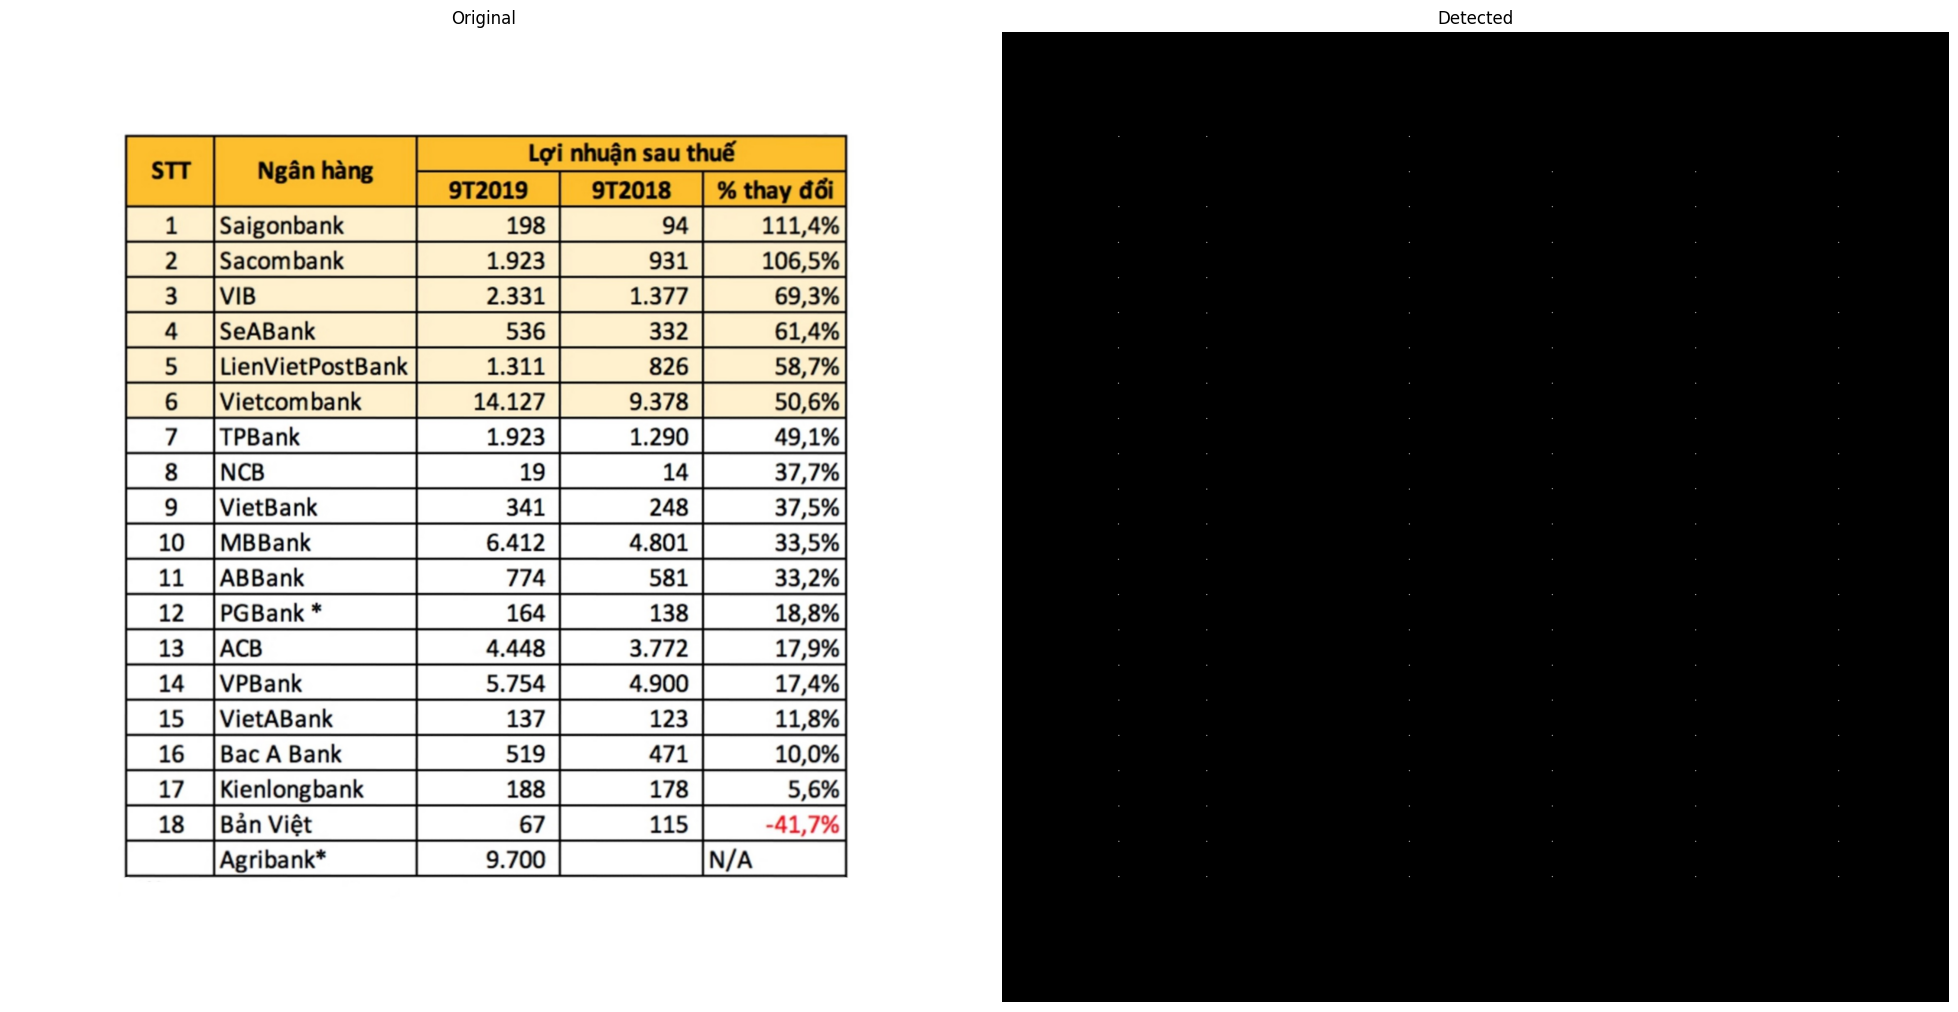

In [7]:
centers = findCenters(dots)
dots_img = drawCenters(image_ok, centers)
display_images_with_labels([(image_ok, "Original"), (dots_img, "Detected")], (1, 2), show_axis=False)

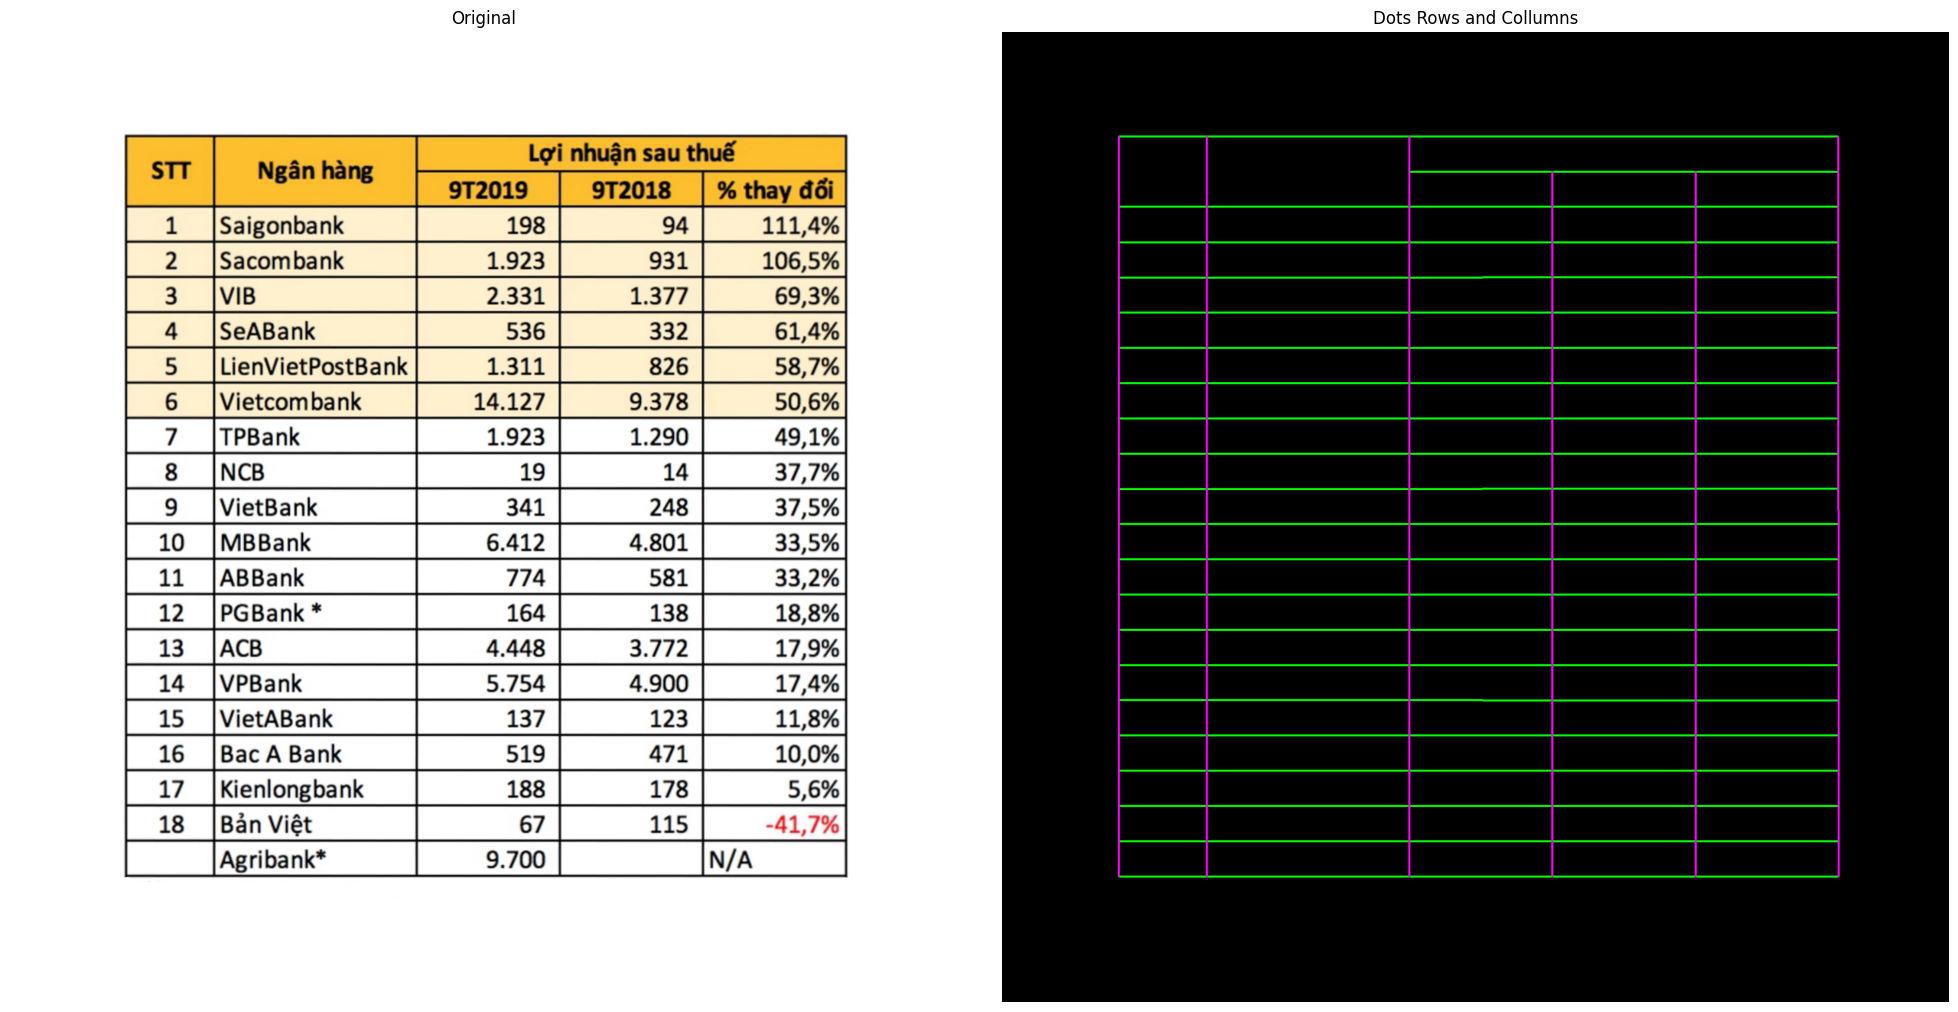

In [8]:
from utils.point import *
rows = split_rows_columns(centers, mode='row')

columns = split_rows_columns(centers, mode='column')
rows_collums_img = draw_rows_columns(dots_img, rows, columns)
display_images_with_labels([(image_ok, "Original"), (rows_collums_img, "Dots Rows and Collumns")], (1, 2), show_axis=False)

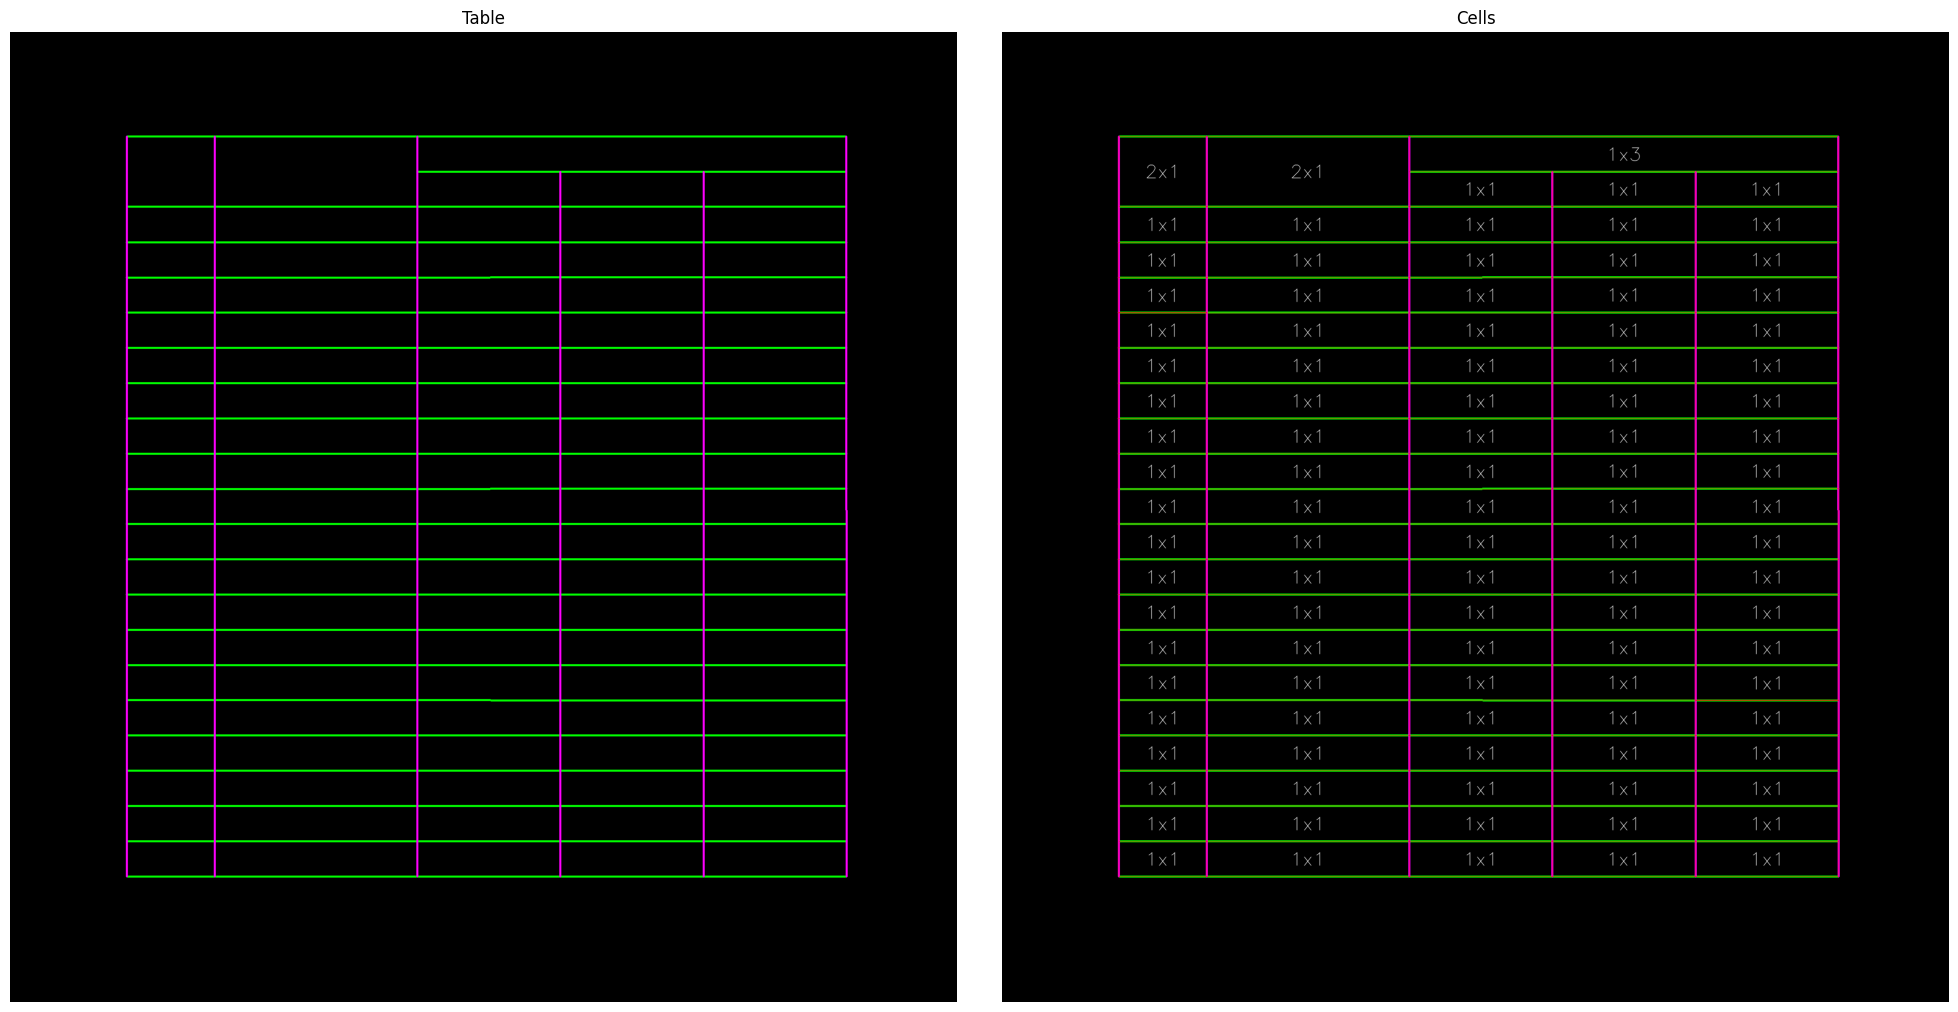

In [9]:
cells = create_cells(rows, columns)
cells_img = draw_cells(rows_collums_img, cells, size=1.5, color=(255,255,255))
display_images_with_labels([(rows_collums_img, "Table"), (cells_img, "Cells")], (1, 2), show_axis=False)

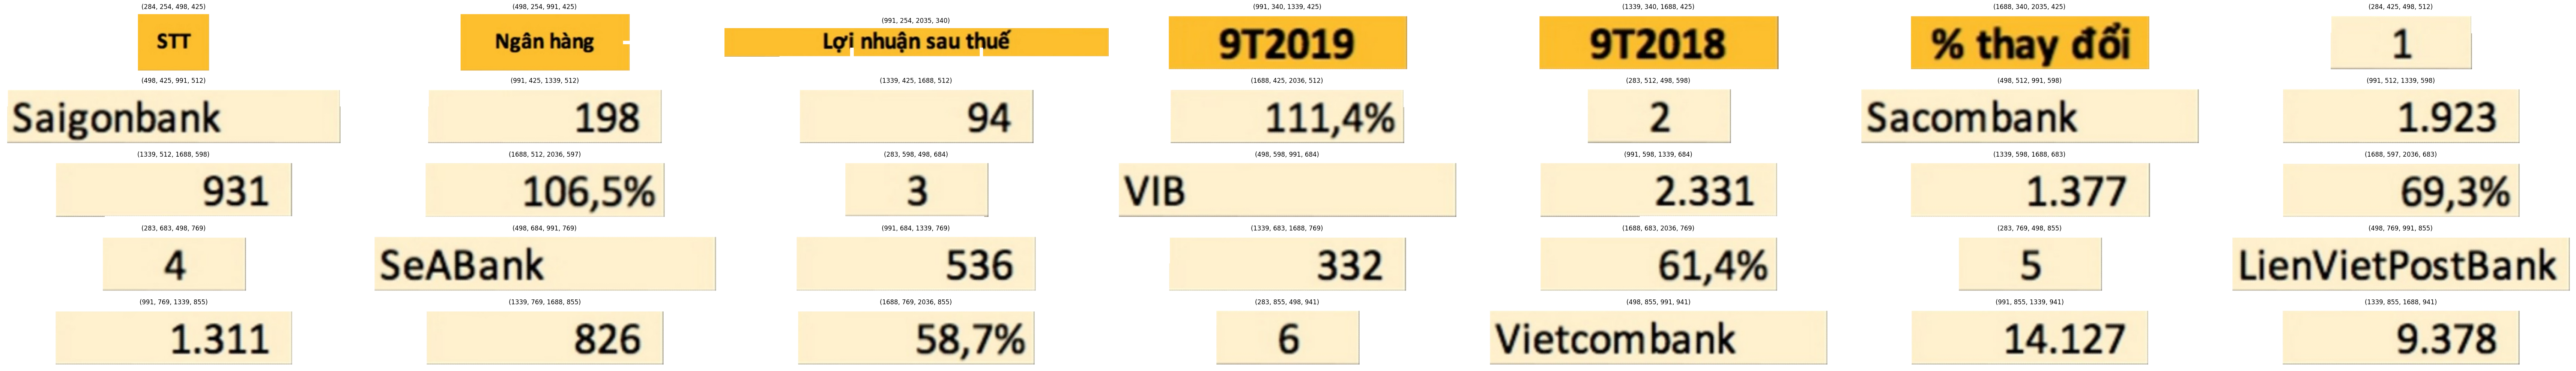

In [10]:
cells_imgs = []
for cell in cells:
    x1,y1,x2,y2 = cell['bbox']
    cropped_image = image_removed[int(y1):int(y2), int(x1):int(x2)]
    img = cropped_image #trim_white(cropped_image)
    cells_imgs += [(img, cell['bbox'])]

display_images_with_labels(cells_imgs[:35], layout = (5, 7), size = (10, 2), show_axis=False)

9T2019


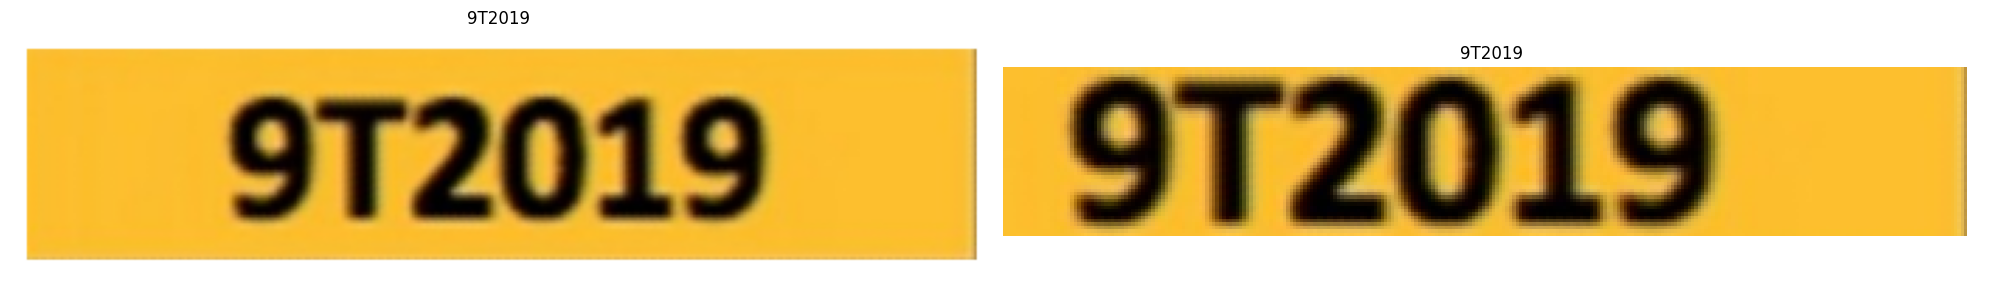

In [11]:
from utils.ocr import detectText
img = cells_imgs[3][0]
text, lines = detectText(img, detector)
print(text)
display_images_with_labels([(img, text)] + list(zip(lines, text.split('\n'))), (1, len(lines)+1), show_axis=False)

In [12]:
texts = []
for cell in cells_imgs:
  img, bbox = cell
  text, lines = detectText(img, detector)
  texts += [text]

print(texts, sep='\n')

['STT', 'Ngân hàng', 'Lợi nhuận sau thuế', '9T2019', '9T2018', '% thay đổi', '1', 'Saigonbank', '198', '94', '111,4%', '2', 'Sacombank', '1.923', '931', '106,5%', '3', 'VIB', '2.331', '1.377', '69,3%', '4', 'SeABank', '536', '332', '61,4%', '5', 'LienVietPostBank', '1.311', '826', '58,7%', '6', 'Vietcombank', '14.127', '9.378', '50,6%', '7', 'TPBank', '1.923', '1.290', '49,1%', '8', 'NCB', '19', '14', '37,7%', '9', 'VietBank', '341', '248', '37,5%', '10', 'MBBank', '6.412', '4.801', '33,5%', '11', 'ABBank', '774', '581', '33,2%', '12', 'PGBANK EMPTICATION', '164', '138', '18,8%', '13', 'ACB', '4.448', '3.772', '17,9%', '14', 'VPBank', '5.754', '4.900', '17,4%', '15', 'VietABank', '137', '123', '11,8%', '16', 'Bac A Bank', '519', '471', '10,0%', '17', 'Kienlongbank', '188', '178', '5,6%', '18', 'Bản Việt', '67', '115', '41,7%', '', 'Agribank?', '9.700', '', 'N/A']


In [13]:
from utils.table import *
cells_imgs = []
for i in range(len(cells)):
  cells[i]['cell text'] = texts[i]
html = cells_to_html(cells).replace('<thead>','<tr>').replace('</thead>','</tr>').replace('\n',"<br>")
html

'<table><tr><th rowspan="2">STT</th><th rowspan="2">Ngân hàng</th><th colspan="3">Lợi nhuận sau thuế</th></tr><tr><td>9T2019</td><td>9T2018</td><td>% thay đổi</td></tr><tr><td>1</td><td>Saigonbank</td><td>198</td><td>94</td><td>111,4%</td></tr><tr><td>2</td><td>Sacombank</td><td>1.923</td><td>931</td><td>106,5%</td></tr><tr><td>3</td><td>VIB</td><td>2.331</td><td>1.377</td><td>69,3%</td></tr><tr><td>4</td><td>SeABank</td><td>536</td><td>332</td><td>61,4%</td></tr><tr><td>5</td><td>LienVietPostBank</td><td>1.311</td><td>826</td><td>58,7%</td></tr><tr><td>6</td><td>Vietcombank</td><td>14.127</td><td>9.378</td><td>50,6%</td></tr><tr><td>7</td><td>TPBank</td><td>1.923</td><td>1.290</td><td>49,1%</td></tr><tr><td>8</td><td>NCB</td><td>19</td><td>14</td><td>37,7%</td></tr><tr><td>9</td><td>VietBank</td><td>341</td><td>248</td><td>37,5%</td></tr><tr><td>10</td><td>MBBank</td><td>6.412</td><td>4.801</td><td>33,5%</td></tr><tr><td>11</td><td>ABBank</td><td>774</td><td>581</td><td>33,2%</td></tr

In [14]:
from IPython.display import display, HTML
new_html = createHTML(image_path, html)
display(HTML(new_html))

In [15]:
from IPython.display import display, HTML
from detection.border_table_detection import recognize
display(HTML(recognize(prePath + "sample/vn1.jpg", detector)))

In [16]:
display(HTML(recognize(prePath + "sample/L1.jpg", detector)))

In [17]:
display(HTML(recognize(prePath + "sample/L2.jpg", detector)))

In [18]:
display(HTML(recognize(prePath + "sample/L3.jpg", detector)))

In [19]:
display(HTML(recognize(prePath + "sample/L4.jpg", detector)))

In [20]:
display(HTML(recognize(prePath + "sample/L5.jpg", detector)))

In [21]:
display(HTML(recognize(prePath + "sample/L6.jpg", detector)))